In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys, os, pathlib, shutil, platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
# import plotly.graph_objs as go
import plotly.express as px


In [3]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
 
plt.rcParams['figure.figsize']=(20,10)

In [4]:
def get_num_unique_as_df(crt_df):
    """
    Utils function

    Returns:
    pd dataframe with 'Column_Name', 'Num_Unique' columns, ordered by Num_Unique
    """
    return (pd.DataFrame.from_records([(col, crt_df[col].nunique()) for col in crt_df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique']))

# def aa(crt_df):
#     
#     mylist = []
#     for col in crt_df.columns:
#         mylist.append((col, crt_df[col].nunique()))
#     return  (pd.DataFrame.from_records(mylist, columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique']))
    
# aa(mySmallData)

### load data

In [5]:
!pwd
! ls -la ./../../data/paav_cargo/T-100Segment_AllCarriers/DL_SelectFields_AllMonths_AllGeo_2019/T_T100_SEGMENT_ALL_CARRIER.csv

/workspace/repos/paav_cargo
-rwxrwxrwx 1 root root 152541805 Nov 27 22:07 ./../../data/paav_cargo/T-100Segment_AllCarriers/DL_SelectFields_AllMonths_AllGeo_2019/T_T100_SEGMENT_ALL_CARRIER.csv


In [6]:
def load_datsets(years_list):
    full_path_list = ['./../../data/paav_cargo/T-100Segment_AllCarriers/DL_SelectFields_AllMonths_AllGeo_'+
                 str(crt_year)
                 +'/T_T100_SEGMENT_ALL_CARRIER.csv' for crt_year in years_list]
    allDatasets= pd.concat([pd.read_csv(str(crt_file_name))  for crt_file_name in full_path_list], keys=years_list).reset_index()
    return allDatasets


years_list = [2019, 2020, 2021, 2022]
myData = load_datsets(years_list)

In [7]:
myData.shape
myData.head(2)
myData.tail(2)

(1425990, 52)

level_0  level_1  DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED  PAYLOAD  \
0     2019        0                   0.0                   1.0  43400.0   
1     2019        1                   0.0                   1.0  26200.0   

   SEATS  PASSENGERS  FREIGHT  MAIL  DISTANCE  ...  DEST_WAC  AIRCRAFT_GROUP  \
0  200.0       157.0      0.0   0.0      92.0  ...        22               6   
1  100.0       100.0      0.0   0.0     145.0  ...        13               6   

  AIRCRAFT_TYPE  AIRCRAFT_CONFIG  YEAR QUARTER MONTH DISTANCE_GROUP CLASS  \
0           699                1  2019       3     7              1     F   
1           678                1  2019       3     7              1     F   

   DATA_SOURCE  
0           DU  
1           DU  

[2 rows x 52 columns]

level_0  level_1  DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED  \
1425988     2022   124453                 785.0                 785.0   
1425989     2022   124454                 796.0                 796.0   

          PAYLOAD   SEATS  PASSENGERS  FREIGHT  MAIL  DISTANCE  ...  DEST_WAC  \
1425988  942000.0  4058.0      2179.0   8980.0   0.0      11.0  ...         5   
1425989  955200.0  4114.0      2218.0   6373.0   0.0      11.0  ...         5   

         AIRCRAFT_GROUP AIRCRAFT_TYPE  AIRCRAFT_CONFIG  YEAR QUARTER MONTH  \
1425988               0            79                1  2022       1     3   
1425989               0            79                1  2022       1     3   

        DISTANCE_GROUP CLASS  DATA_SOURCE  
1425988              1     F           DU  
1425989              1     F           DU  

[2 rows x 52 columns]

In [8]:
myData.info()
myData.shape
# myData["FREIGHT", "YEAR", "MONTH"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425990 entries, 0 to 1425989
Data columns (total 52 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   level_0                1425990 non-null  int64  
 1   level_1                1425990 non-null  int64  
 2   DEPARTURES_SCHEDULED   1425990 non-null  float64
 3   DEPARTURES_PERFORMED   1425990 non-null  float64
 4   PAYLOAD                1425990 non-null  float64
 5   SEATS                  1425990 non-null  float64
 6   PASSENGERS             1425990 non-null  float64
 7   FREIGHT                1425990 non-null  float64
 8   MAIL                   1425990 non-null  float64
 9   DISTANCE               1425990 non-null  float64
 10  RAMP_TO_RAMP           1425990 non-null  float64
 11  AIR_TIME               1425990 non-null  float64
 12  UNIQUE_CARRIER         1425990 non-null  object 
 13  AIRLINE_ID             1425990 non-null  int64  
 14  UNIQUE_CARRIER_NAM

(1425990, 52)

In [9]:
myData['ORIGIN_STATE_NM'].unique()
myData['ORIGIN_COUNTRY_NAME'].unique()    

array(['New Jersey', 'New York', 'Georgia', 'Texas', 'Arizona',
       'Connecticut', 'Massachusetts', 'California', 'Maryland',
       'South Carolina', 'Ohio', 'Virginia', 'Colorado', 'Michigan',
       'Alaska', 'Utah', 'Missouri', 'British Columbia', nan, 'Nebraska',
       'Indiana', 'Illinois', 'Iowa', 'West Virginia', 'Wyoming',
       'Mississippi', 'North Carolina', 'Montana', 'Alabama', 'Idaho',
       'North Dakota', 'Arkansas', 'Wisconsin', 'South Dakota',
       'New Mexico', 'Pennsylvania', 'Kentucky', 'Tennessee', 'Ontario',
       'Florida', 'Minnesota', 'Quebec', 'Nevada', 'Oregon', 'Washington',
       'Kansas', 'Hawaii', 'Delaware', 'Louisiana', 'Oklahoma',
       'Rhode Island', 'Maine', 'New Hampshire', 'Puerto Rico',
       'U.S. Pacific Trust Territories and Possessions', 'Vermont',
       'Alberta', 'Manitoba', 'Nova Scotia', 'Nunavut Territory',
       'Saskatchewan', 'Newfoundland and Labrador', 'New Brunswick',
       'U.S. Virgin Islands', 'Northwest Territo

array(['United States', 'Canada', 'Mexico', 'Cayman Islands', 'Ecuador',
       'Jamaica', 'Dominican Republic', 'Germany', 'Hong Kong', 'China',
       'Italy', 'Croatia', 'Switzerland', 'United Arab Emirates', 'Samoa',
       'Kiribati', 'Fiji', 'Spain', 'Australia', 'Barbados',
       'The Bahamas', 'Turks and Caicos Islands', 'Panama', 'Belgium',
       'France', 'United Kingdom', 'India', 'Portugal', 'Sweden',
       'Denmark', 'Norway', 'Russia', 'Saudi Arabia', 'Ireland',
       'Guatemala', 'Nicaragua', 'El Salvador', 'Honduras',
       'French Polynesia', 'Peru', 'Japan', 'Colombia', 'Cape Verde',
       'Bermuda', 'Chile', 'Israel', 'Sint Maarten', 'Iceland', 'Austria',
       'Philippines', 'Ghana', 'Senegal', 'South Africa', 'Thailand',
       'Singapore', 'Greece', 'South Korea', 'Costa Rica',
       'Federated States of Micronesia', 'Romania', 'Guyana', 'Haiti',
       'Suriname', 'Trinidad and Tobago', 'British Virgin Islands',
       'Aruba', 'Antigua and Barbuda', 'Cub

### Limit analysis to a certain geo (only one state, or whole country)

In [10]:
geo_aggregation =  {'STATE':'Texas'}#{'STATE':'Arizona'} 
geo_aggregation = {'COUNTRY':'United States'}

In [11]:
if 'STATE' in geo_aggregation.keys():
    mySmallData = myData.loc[myData['ORIGIN_STATE_NM'] .isin( geo_aggregation.values())]
    print('geo_aggregation is STATE')
    print(geo_aggregation.keys())
    print(geo_aggregation.values())
    
if 'COUNTRY' in geo_aggregation.keys():
    mySmallData = myData.loc[myData['ORIGIN_COUNTRY_NAME'] .isin( geo_aggregation.values())]
    print('geo_aggregation is country')
    print(geo_aggregation.keys())
    print(geo_aggregation.values())
    
    
mySmallData = mySmallData.rename({'level_0': 'OrigYEAR'}, axis=1)

mySmallData.head(2)
mySmallData.tail(2)



geo_aggregation is country
dict_keys(['COUNTRY'])
dict_values(['United States'])


OrigYEAR  level_1  DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED  PAYLOAD  \
0      2019        0                   0.0                   1.0  43400.0   
1      2019        1                   0.0                   1.0  26200.0   

   SEATS  PASSENGERS  FREIGHT  MAIL  DISTANCE  ...  DEST_WAC  AIRCRAFT_GROUP  \
0  200.0       157.0      0.0   0.0      92.0  ...        22               6   
1  100.0       100.0      0.0   0.0     145.0  ...        13               6   

  AIRCRAFT_TYPE  AIRCRAFT_CONFIG  YEAR QUARTER MONTH DISTANCE_GROUP CLASS  \
0           699                1  2019       3     7              1     F   
1           678                1  2019       3     7              1     F   

   DATA_SOURCE  
0           DU  
1           DU  

[2 rows x 52 columns]

OrigYEAR  level_1  DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED  \
1425988      2022   124453                 785.0                 785.0   
1425989      2022   124454                 796.0                 796.0   

          PAYLOAD   SEATS  PASSENGERS  FREIGHT  MAIL  DISTANCE  ...  DEST_WAC  \
1425988  942000.0  4058.0      2179.0   8980.0   0.0      11.0  ...         5   
1425989  955200.0  4114.0      2218.0   6373.0   0.0      11.0  ...         5   

         AIRCRAFT_GROUP AIRCRAFT_TYPE  AIRCRAFT_CONFIG  YEAR QUARTER MONTH  \
1425988               0            79                1  2022       1     3   
1425989               0            79                1  2022       1     3   

        DISTANCE_GROUP CLASS  DATA_SOURCE  
1425988              1     F           DU  
1425989              1     F           DU  

[2 rows x 52 columns]

In [12]:
mySmallData.info()
mySmallData.shape
mySmallData[["FREIGHT", "YEAR", "MONTH", "DISTANCE", "AIR_TIME"]].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302115 entries, 0 to 1425989
Data columns (total 52 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   OrigYEAR               1302115 non-null  int64  
 1   level_1                1302115 non-null  int64  
 2   DEPARTURES_SCHEDULED   1302115 non-null  float64
 3   DEPARTURES_PERFORMED   1302115 non-null  float64
 4   PAYLOAD                1302115 non-null  float64
 5   SEATS                  1302115 non-null  float64
 6   PASSENGERS             1302115 non-null  float64
 7   FREIGHT                1302115 non-null  float64
 8   MAIL                   1302115 non-null  float64
 9   DISTANCE               1302115 non-null  float64
 10  RAMP_TO_RAMP           1302115 non-null  float64
 11  AIR_TIME               1302115 non-null  float64
 12  UNIQUE_CARRIER         1302115 non-null  object 
 13  AIRLINE_ID             1302115 non-null  int64  
 14  UNIQUE_CARRIER_NAM

(1302115, 52)

FREIGHT          YEAR         MONTH      DISTANCE      AIR_TIME
count  1.302115e+06  1.302115e+06  1.302115e+06  1.302115e+06  1.302115e+06
mean   9.883743e+04  2.020157e+03  6.184493e+00  9.307207e+02  2.176182e+03
std    5.126057e+05  9.920491e-01  3.595767e+00  1.042926e+03  3.950271e+03
min    0.000000e+00  2.019000e+03  1.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  2.019000e+03  3.000000e+00  2.900000e+02  1.140000e+02
50%    0.000000e+00  2.020000e+03  6.000000e+00  6.550000e+02  6.000000e+02
75%    2.783000e+03  2.021000e+03  9.000000e+00  1.142000e+03  2.711000e+03
max    3.731747e+07  2.022000e+03  1.200000e+01  1.064100e+04  2.971970e+05

In [13]:
get_num_unique_as_df(mySmallData)

Column_Name  Num_Unique
30    ORIGIN_COUNTRY_NAME           1
29         ORIGIN_COUNTRY           1
0                OrigYEAR           4
47                QUARTER           4
46                   YEAR           4
45        AIRCRAFT_CONFIG           4
50                  CLASS           4
19          CARRIER_GROUP           4
51            DATA_SOURCE           4
16                 REGION           5
20      CARRIER_GROUP_NEW           8
43         AIRCRAFT_GROUP           9
48                  MONTH          12
49         DISTANCE_GROUP          22
28        ORIGIN_STATE_NM          53
27      ORIGIN_STATE_FIPS          53
26       ORIGIN_STATE_ABR          53
31             ORIGIN_WAC          53
38        DEST_STATE_FIPS          53
37         DEST_STATE_ABR          66
39          DEST_STATE_NM          66
41      DEST_COUNTRY_NAME         164
40           DEST_COUNTRY         164
44          AIRCRAFT_TYPE         187
42               DEST_WAC         229
14    UNIQUE_CARRIER_NAME         348
13             AIRLINE_ID         348
12         UNIQUE_CARRIER         348
17                CARRIER         351
18           CARRIER_NAME         356
15  UNIQUE_CARRIER_ENTITY         409
3    DEPARTURES_PERFORMED         615
2    DEPARTURES_SCHEDULED         652
23  ORIGIN_CITY_MARKET_ID        1418
25       ORIGIN_CITY_NAME        1471
21      ORIGIN_AIRPORT_ID        1646
24                 ORIGIN        1648
22  ORIGIN_AIRPORT_SEQ_ID        1715
34    DEST_CITY_MARKET_ID        2136
36         DEST_CITY_NAME        2202
32        DEST_AIRPORT_ID        2420
35                   DEST        2424
33    DEST_AIRPORT_SEQ_ID        2526
9                DISTANCE        5136
5                   SEATS       23759
6              PASSENGERS       24850
11               AIR_TIME       26715
10           RAMP_TO_RAMP       29496
8                    MAIL       50390
7                 FREIGHT      178687
4                 PAYLOAD      253568
1                 level_1      486664

In [14]:
mySmallData['ORIGIN_STATE_NM'].unique()
mySmallData['ORIGIN_COUNTRY_NAME'].unique()
mySmallData['DEST_COUNTRY_NAME'].unique()
mySmallData['YEAR'].unique()

array(['New Jersey', 'New York', 'Georgia', 'Texas', 'Arizona',
       'Connecticut', 'Massachusetts', 'California', 'Maryland',
       'South Carolina', 'Ohio', 'Virginia', 'Colorado', 'Michigan',
       'Alaska', 'Utah', 'Missouri', 'Nebraska', 'Indiana', 'Illinois',
       'Iowa', 'West Virginia', 'Wyoming', 'Mississippi',
       'North Carolina', 'Montana', 'Alabama', 'Idaho', 'North Dakota',
       'Arkansas', 'Wisconsin', 'South Dakota', 'New Mexico',
       'Pennsylvania', 'Kentucky', 'Tennessee', 'Florida', 'Minnesota',
       'Nevada', 'Oregon', 'Washington', 'Kansas', 'Hawaii', 'Delaware',
       'Louisiana', 'Oklahoma', 'Rhode Island', 'Maine', 'New Hampshire',
       'Puerto Rico', 'U.S. Pacific Trust Territories and Possessions',
       'Vermont', 'U.S. Virgin Islands'], dtype=object)

array(['United States'], dtype=object)

array(['United States', 'Mexico', 'Canada', 'Haiti', 'Dominican Republic',
       'Colombia', 'Bermuda', 'Ireland', 'Germany', 'Norway',
       'United Kingdom', 'China', 'Italy', 'Switzerland',
       'United Arab Emirates', 'Netherlands', 'Belgium', 'Samoa',
       'Kiribati', 'Fiji', 'Spain', 'Australia', 'The Bahamas',
       'Turks and Caicos Islands', 'Barbados', 'Panama', 'France',
       'Turkey', 'Sweden', 'India', 'Portugal', 'Denmark', 'Russia',
       'Saudi Arabia', 'El Salvador', 'Guatemala', 'Honduras',
       'Nicaragua', 'French Polynesia', 'Peru', 'Japan', 'Hong Kong',
       'Iceland', 'Trinidad and Tobago', 'Cape Verde', 'South Korea',
       'Cayman Islands', 'Austria', 'Philippines', 'Ghana', 'Senegal',
       'South Africa', 'Singapore', 'Greece', 'Jamaica', 'Ecuador',
       'Uruguay', 'Belize', 'Federated States of Micronesia', 'Guyana',
       'Suriname', 'British Virgin Islands', 'Antigua and Barbuda',
       'Saint Kitts and Nevis', 'Costa Rica', 'Cuba', 'Ar

array([2019, 2020, 2021, 2022])

### Create grouping column to allow group_by month and year

In [15]:
mySmallData['FullDate'] = mySmallData['YEAR'].map(str) +"-"+ mySmallData["MONTH"].map(str) + "-01"
mySmallData['FullDate'] = pd.to_datetime(mySmallData['FullDate'],format='%Y-%m-%d')

data_column='FREIGHT'

if 'STATE' in geo_aggregation.keys():
    geoAggColumn = 'ORIGIN_STATE_NM'
    
if 'COUNTRY' in geo_aggregation.keys():
    geoAggColumn = 'ORIGIN_COUNTRY_NAME'

regressionData = mySmallData.groupby([geoAggColumn,'FullDate'])[data_column].sum().reset_index()

regressionData.sort_values(by=['FullDate'], ascending=True, inplace=True)
regressionData

ORIGIN_COUNTRY_NAME   FullDate       FREIGHT
0        United States 2019-01-01  3.008939e+09
1        United States 2019-02-01  2.690377e+09
2        United States 2019-03-01  3.196169e+09
3        United States 2019-04-01  3.008646e+09
4        United States 2019-05-01  3.189460e+09
5        United States 2019-06-01  3.074642e+09
6        United States 2019-07-01  3.081732e+09
7        United States 2019-08-01  3.200322e+09
8        United States 2019-09-01  2.954616e+09
9        United States 2019-10-01  3.268399e+09
10       United States 2019-11-01  3.163839e+09
11       United States 2019-12-01  3.368555e+09
12       United States 2020-01-01  2.951273e+09
13       United States 2020-02-01  2.733092e+09
14       United States 2020-03-01  3.137388e+09
15       United States 2020-04-01  2.969226e+09
16       United States 2020-05-01  3.160010e+09
17       United States 2020-06-01  3.235409e+09
18       United States 2020-07-01  3.387474e+09
19       United States 2020-08-01  3.256920e+09
20       United States 2020-09-01  3.344154e+09
21       United States 2020-10-01  3.575603e+09
22       United States 2020-11-01  3.426099e+09
23       United States 2020-12-01  3.869473e+09
24       United States 2021-01-01  3.367169e+09
25       United States 2021-02-01  2.903368e+09
26       United States 2021-03-01  3.596390e+09
27       United States 2021-04-01  3.561978e+09
28       United States 2021-05-01  3.528241e+09
29       United States 2021-06-01  3.584198e+09
30       United States 2021-07-01  3.633613e+09
31       United States 2021-08-01  3.551634e+09
32       United States 2021-09-01  3.531002e+09
33       United States 2021-10-01  3.695020e+09
34       United States 2021-11-01  3.565951e+09
35       United States 2021-12-01  4.026505e+09
36       United States 2022-01-01  3.201107e+09
37       United States 2022-02-01  3.070169e+09
38       United States 2022-03-01  3.629533e+09

FREIGHT
FullDate                
2019-01-01  3.008939e+09
2019-02-01  2.690377e+09
2019-03-01  3.196169e+09
2019-04-01  3.008646e+09
2019-05-01  3.189460e+09
2019-06-01  3.074642e+09
2019-07-01  3.081732e+09
2019-08-01  3.200322e+09
2019-09-01  2.954616e+09
2019-10-01  3.268399e+09
2019-11-01  3.163839e+09
2019-12-01  3.368555e+09
2020-01-01  2.951273e+09
2020-02-01  2.733092e+09
2020-03-01  3.137388e+09
2020-04-01  2.969226e+09
2020-05-01  3.160010e+09
2020-06-01  3.235409e+09
2020-07-01  3.387474e+09
2020-08-01  3.256920e+09
2020-09-01  3.344154e+09
2020-10-01  3.575603e+09
2020-11-01  3.426099e+09
2020-12-01  3.869473e+09
2021-01-01  3.367169e+09
2021-02-01  2.903368e+09
2021-03-01  3.596390e+09
2021-04-01  3.561978e+09
2021-05-01  3.528241e+09
2021-06-01  3.584198e+09
2021-07-01  3.633613e+09
2021-08-01  3.551634e+09
2021-09-01  3.531002e+09
2021-10-01  3.695020e+09
2021-11-01  3.565951e+09
2021-12-01  4.026505e+09
2022-01-01  3.201107e+09
2022-02-01  3.070169e+09
2022-03-01  3.629533e+09

<AxesSubplot:xlabel='FullDate'>

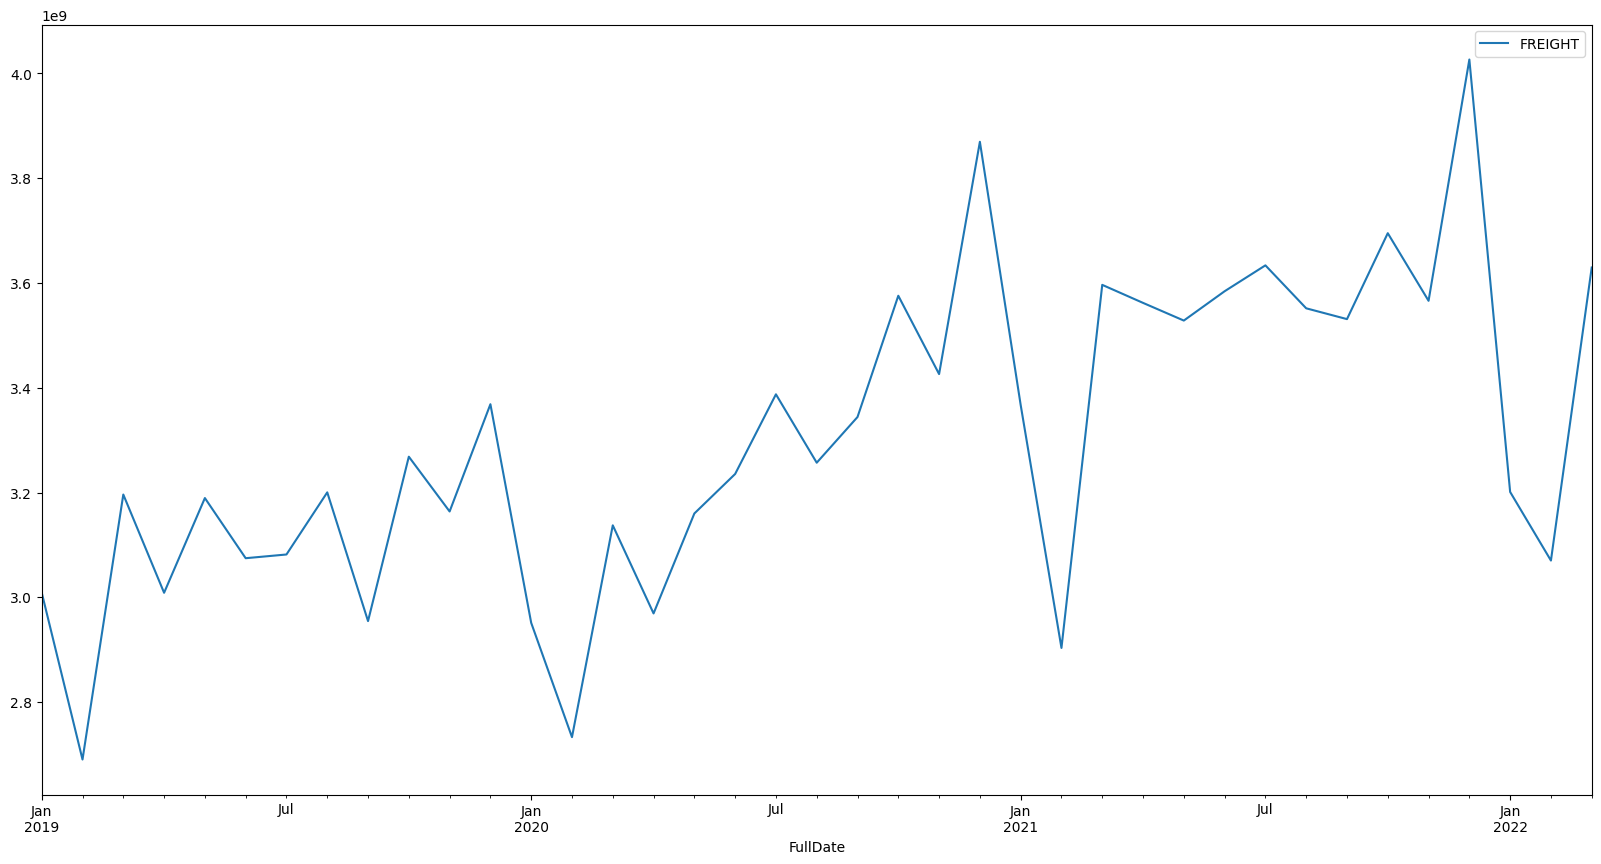

In [16]:
regressionData.index = pd.to_datetime(regressionData['FullDate'],format='%Y-%m-%d')
regressionData.drop(columns=['FullDate', geoAggColumn],inplace=True)
regressionData.sort_index(inplace=True)
regressionData
regressionData.plot()

### Plotting exercise - data split by time index

Text(0, 0.5, 'Cargo data')

Text(0.5, 0, 'Date')

(array([17897., 18017., 18140., 18262., 18383., 18506., 18628., 18748.,
        18871., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Train/Test split for Cargo Data')

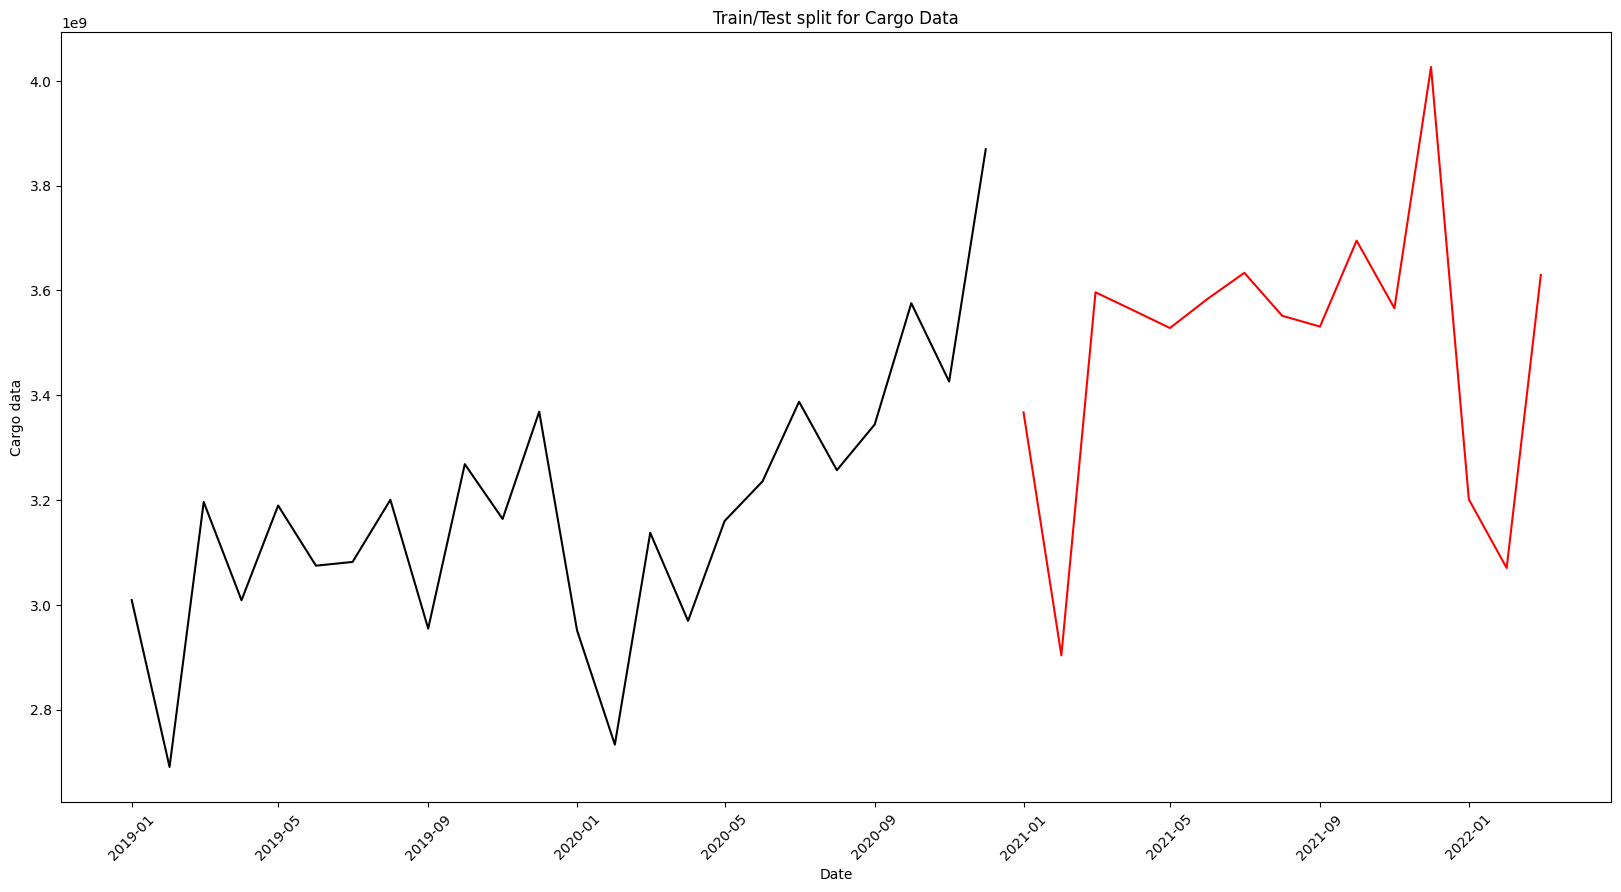

In [17]:
train = regressionData[regressionData.index < pd.to_datetime("2021-01-01", format='%Y-%m-%d')]
test = regressionData[regressionData.index >= pd.to_datetime("2021-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Cargo data')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Cargo Data")
plt.show()

### See trends, seasonality (using statsmodels.tsa.seasonal import seasonal_decompose)

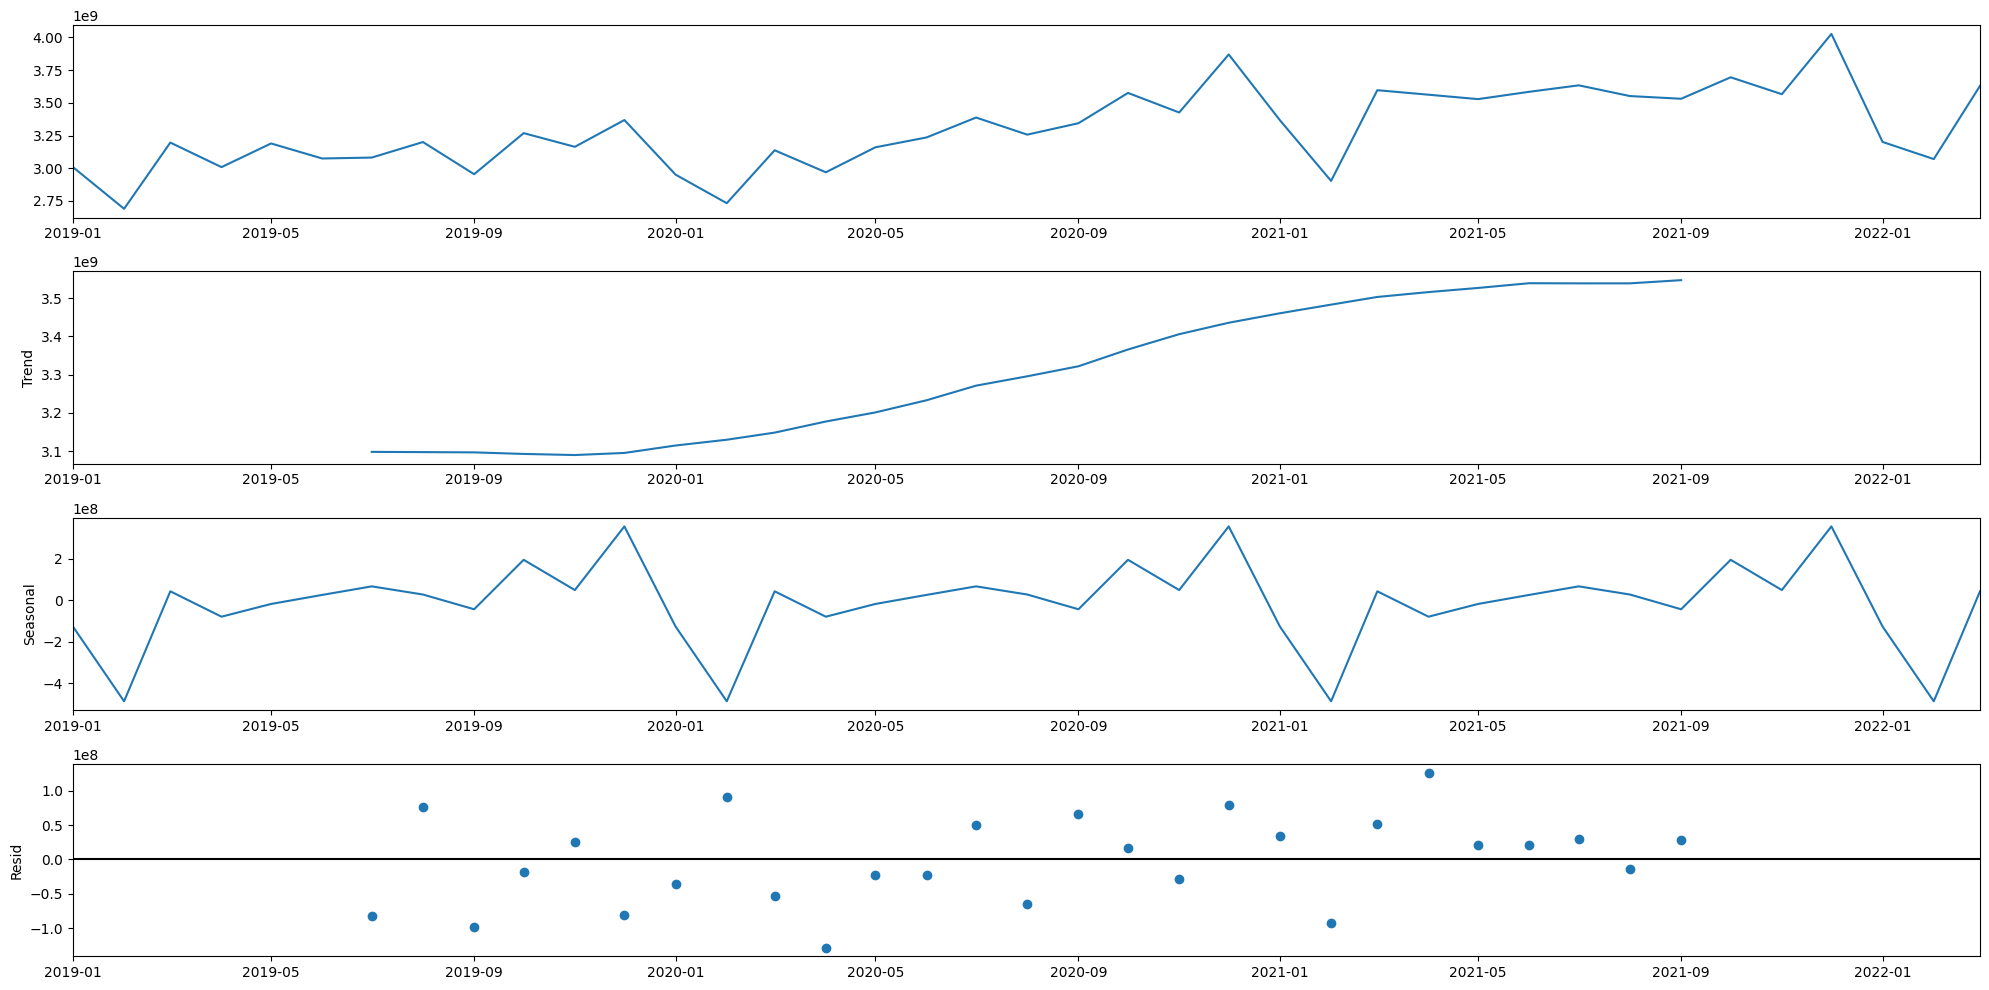

In [18]:
decompose_data = seasonal_decompose(regressionData, model="additive")
decompose_data.plot();

In [19]:

def prophet_fc(df):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=120, freq='M')
    forecast = m.predict(future)
    return forecast, future, m

    
fc_regression_data=regressionData.reset_index()
fc_regression_data = fc_regression_data.rename(columns={'FullDate': 'ds',
                        data_column: 'y'})
fc_regression_data
# fc, future, model = prophet_fc(fc_regression_data)   
# future
# fc
# fc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds             y
0  2019-01-01  3.008939e+09
1  2019-02-01  2.690377e+09
2  2019-03-01  3.196169e+09
3  2019-04-01  3.008646e+09
4  2019-05-01  3.189460e+09
5  2019-06-01  3.074642e+09
6  2019-07-01  3.081732e+09
7  2019-08-01  3.200322e+09
8  2019-09-01  2.954616e+09
9  2019-10-01  3.268399e+09
10 2019-11-01  3.163839e+09
11 2019-12-01  3.368555e+09
12 2020-01-01  2.951273e+09
13 2020-02-01  2.733092e+09
14 2020-03-01  3.137388e+09
15 2020-04-01  2.969226e+09
16 2020-05-01  3.160010e+09
17 2020-06-01  3.235409e+09
18 2020-07-01  3.387474e+09
19 2020-08-01  3.256920e+09
20 2020-09-01  3.344154e+09
21 2020-10-01  3.575603e+09
22 2020-11-01  3.426099e+09
23 2020-12-01  3.869473e+09
24 2021-01-01  3.367169e+09
25 2021-02-01  2.903368e+09
26 2021-03-01  3.596390e+09
27 2021-04-01  3.561978e+09
28 2021-05-01  3.528241e+09
29 2021-06-01  3.584198e+09
30 2021-07-01  3.633613e+09
31 2021-08-01  3.551634e+09
32 2021-09-01  3.531002e+09
33 2021-10-01  3.695020e+09
34 2021-11-01  3.565951e+09
35 2021-12-01  4.026505e+09
36 2022-01-01  3.201107e+09
37 2022-02-01  3.070169e+09
38 2022-03-01  3.629533e+09

In [20]:
# plot_plotly(model, fc)

In [21]:
def forecast_in_sample(hold_out_samples_count, df, growth = 'linear'):
    train_data = df.drop(df.index[-hold_out_samples_count:])
    print(train_data.head(4), train_data.tail(4))
    print(train_data.shape)
    
    model = Prophet(growth=growth)
    model.fit(train_data)
    
    future = df[['ds']].reset_index()                         # predicts for all ds values
    forecast = model.predict(future)
    return forecast, model

def forecast_future(future_samples_count, df, growth = 'linear'):
    model = Prophet(growth=growth)
    model.fit(df)
    
    future = model.make_future_dataframe(periods=future_samples_count, freq='m')

    forecast = model.predict(future)
    return forecast, model


def forecasted_percentiles(fc_model, input_df, percentiles = [2.5, 5, 20, 80, 95, 97.5, 50]):     
    forecasted_samples = fc_model.predictive_samples(input_df)
    forecasted_stats=pd.DataFrame(data=np.transpose(np.percentile(forecasted_samples['yhat'], percentiles, axis=1 ))
             ,  columns = ['pct_'+str(x) for x in percentiles])
    forecasted_stats.insert(loc=0, column='ds', value=input_df['ds'])
    return forecasted_stats 

## In-sample analysis (understand fc performance)

In [22]:
hold_out_samples=5
forecasted_df, fc_model = forecast_in_sample(hold_out_samples, fc_regression_data)

00:44:32 - cmdstanpy - INFO - Chain [1] start processing


          ds             y
0 2019-01-01  3.008939e+09
1 2019-02-01  2.690377e+09
2 2019-03-01  3.196169e+09
3 2019-04-01  3.008646e+09            ds             y
30 2021-07-01  3.633613e+09
31 2021-08-01  3.551634e+09
32 2021-09-01  3.531002e+09
33 2021-10-01  3.695020e+09
(34, 2)


00:44:32 - cmdstanpy - INFO - Chain [1] done processing


#### static(non-interactive) model plot  

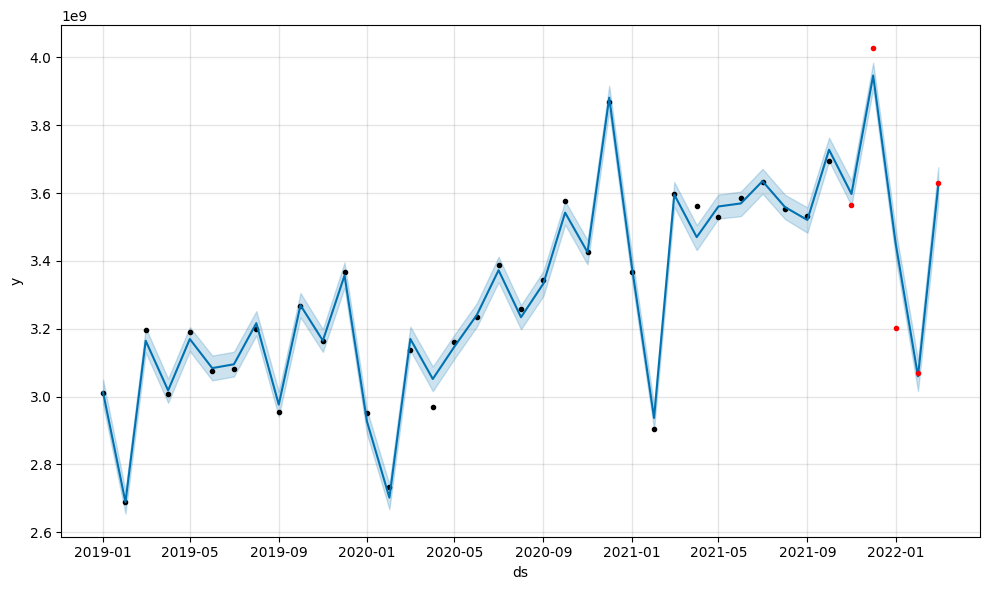

In [23]:
uncertainty=True
fig1 = fc_model.plot(forecasted_df, uncertainty = uncertainty)
figax = fig1.axes[0]
figax.plot(fc_regression_data[-hold_out_samples:]['ds'].dt.to_pydatetime(), 
            fc_regression_data[-hold_out_samples:][['y']], 'r.',
            label='(Future) Observed data points')

#### interactive model plot  

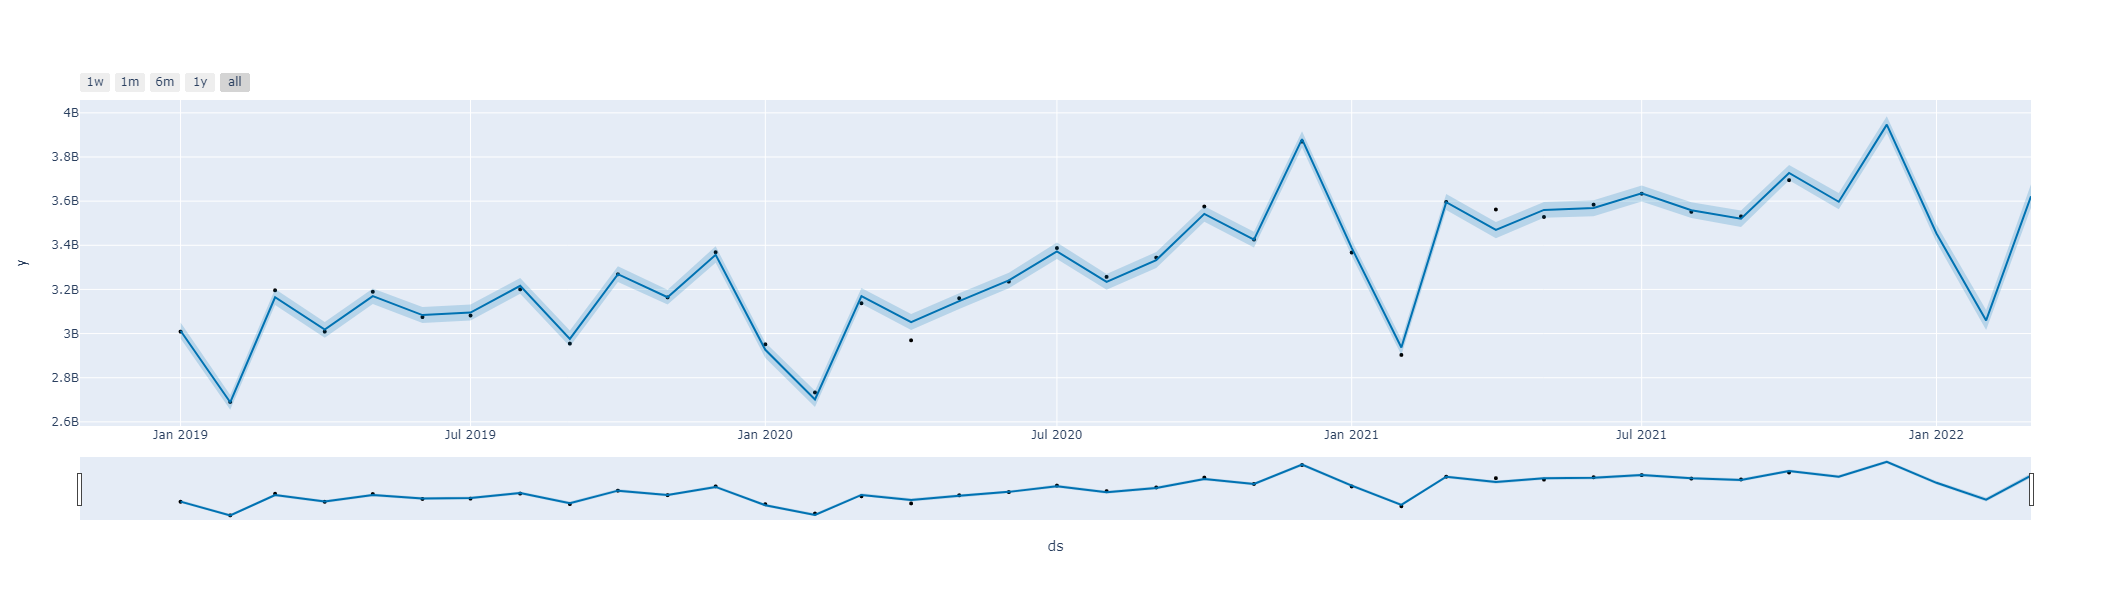

In [24]:
plot_plotly(fc_model, forecasted_df)

## Forecasting analysis

In [25]:
future_samples_count = 36
forecasted_df1, fc_model1 = forecast_future(future_samples_count, fc_regression_data)

00:44:33 - cmdstanpy - INFO - Chain [1] start processing
00:44:34 - cmdstanpy - INFO - Chain [1] done processing


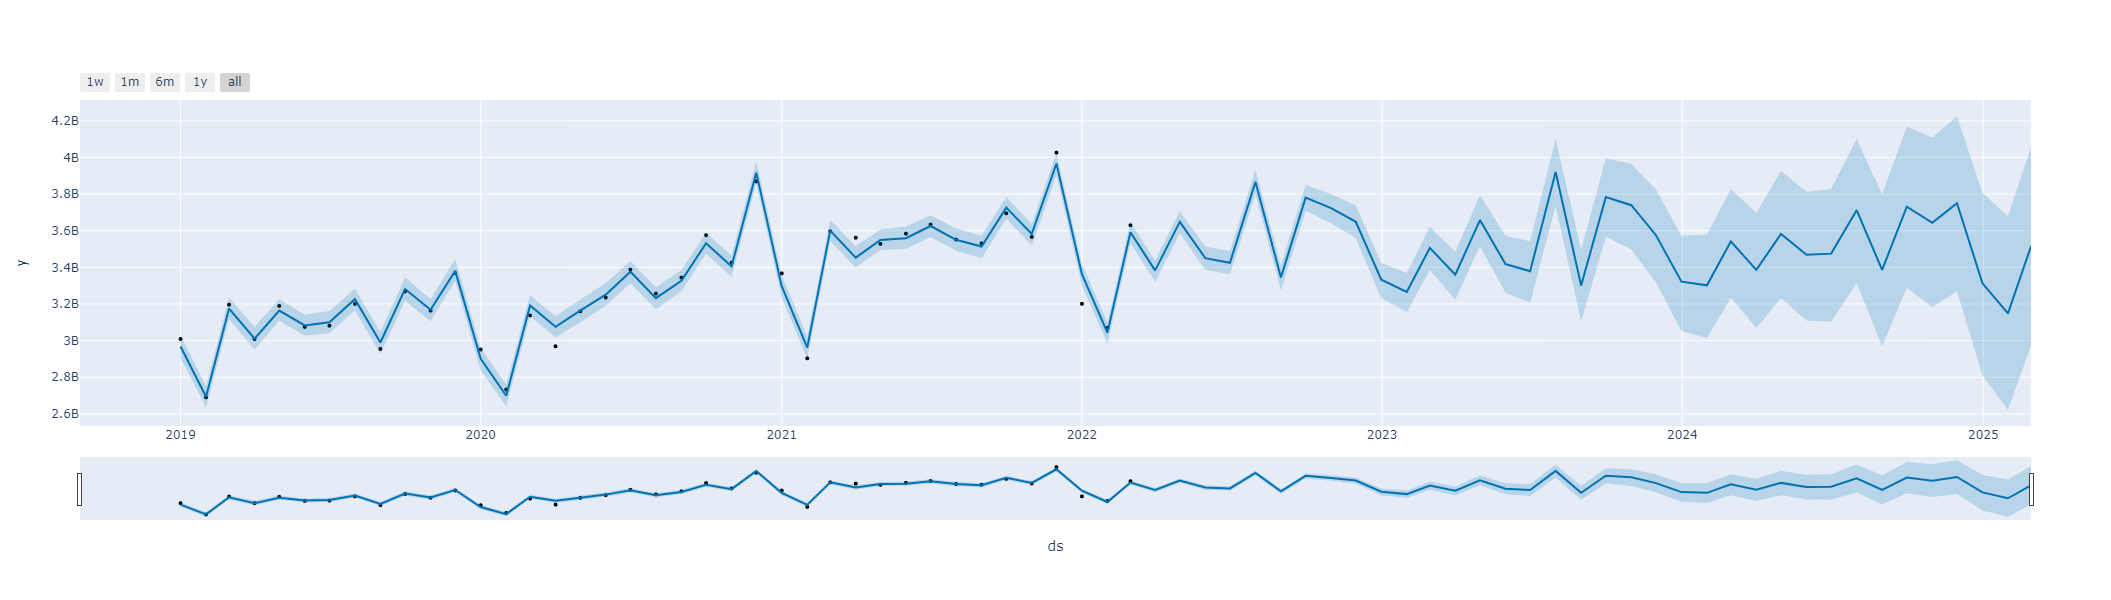

In [26]:
plot_plotly(fc_model1, forecasted_df1)

ds       pct_2.5         pct_5        pct_15        pct_85  \
0  2019-01-01  2.881254e+09  2.894744e+09  2.921855e+09  3.016998e+09   
1  2019-02-01  2.601618e+09  2.612585e+09  2.643529e+09  2.740824e+09   
2  2019-03-01  3.080979e+09  3.095061e+09  3.122283e+09  3.223483e+09   
3  2019-04-01  2.922055e+09  2.937171e+09  2.962336e+09  3.062267e+09   
4  2019-05-01  3.073410e+09  3.088216e+09  3.115642e+09  3.209413e+09   
..        ...           ...           ...           ...           ...   
70 2024-10-31  2.836629e+09  3.008105e+09  3.255285e+09  4.036219e+09   
71 2024-11-30  2.925405e+09  3.105049e+09  3.341590e+09  4.155749e+09   
72 2024-12-31  2.446933e+09  2.643375e+09  2.896230e+09  3.740664e+09   
73 2025-01-31  2.251546e+09  2.438748e+09  2.698834e+09  3.593977e+09   
74 2025-02-28  2.571454e+09  2.744790e+09  3.048214e+09  3.982640e+09   

          pct_95      pct_97.5        pct_50  
0   3.041766e+09  3.056161e+09  2.969763e+09  
1   2.765788e+09  2.776230e+09  2.693563e+09  
2   3.252250e+09  3.267319e+09  3.174246e+09  
3   3.094843e+09  3.105722e+09  3.012826e+09  
4   3.236062e+09  3.252936e+09  3.162385e+09  
..           ...           ...           ...  
70  4.250508e+09  4.386630e+09  3.641721e+09  
71  4.387822e+09  4.541506e+09  3.751537e+09  
72  3.978261e+09  4.150454e+09  3.301776e+09  
73  3.858596e+09  4.023786e+09  3.145156e+09  
74  4.277233e+09  4.410835e+09  3.512868e+09  

[75 rows x 8 columns]

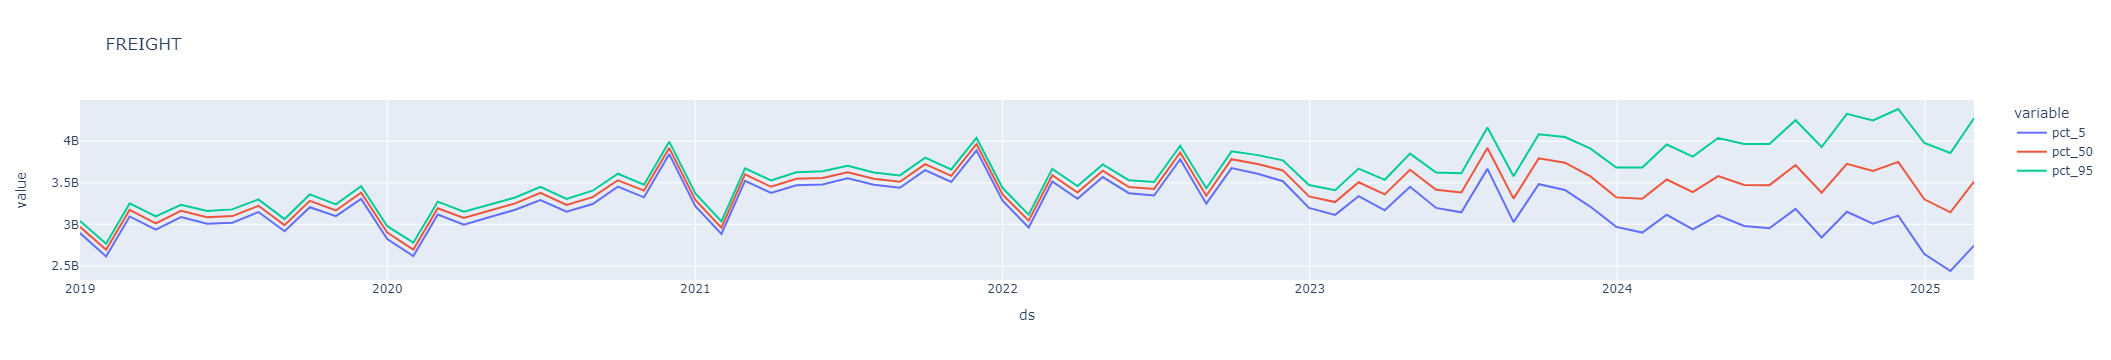

In [27]:
percentiles = [2.5, 5, 15, 85, 95, 97.5, 50]
forecasted_stats = forecasted_percentiles(fc_model1, forecasted_df1, percentiles = percentiles)
forecasted_stats

fig = px.line(forecasted_stats, x="ds", y=['pct_5','pct_50','pct_95'], #y=fc.columns,
              hover_data={"ds": "|%B %d, %Y"},
              title=data_column)
fig.show()